##  Exercise- Amazon Fine Food Reviews LSTM Model. 


# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2)Getting Vocabulary of all the words 
Getting Frequency of each word 
Indexing Each word
Convert your data into imdb dataset format
Run the lstm model and Report the Accuracy



<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file
downloaded = drive.CreateFile({'id':'1il5Ue_HoshloviEApbrO5ncK729yeUZY'}) # replace the id with id of file you want to access
downloaded.GetContentFile('database.sqlite')  



# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords

from tqdm import tqdm
import os


In [4]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [8]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [0]:
#Sorting data according to Time in ascending order
final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

## Taking first 60k Rows

```
# This is formatted as code
```



In [17]:
# We will collect first 60000 rows without repetition from time_sorted_data dataframe
final = final[:60000]
print(final.shape)
final.head()

(60000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


#  [3] Preprocessing

Tokenization basically refers to splitting up a larger body of text into smaller lines, words or even creating words for a non-English language. 

A sentence or data can be split into words using the method word_tokenize():

Tokenizer to vectorize the text and convert it into sequence of integers after restricting the tokenizer to use only top most common 2500 words. I used pad_sequences to convert the sequences into 2-D numpy array.

In [18]:
final['Text'].isnull().values.any()
final['Score'].isnull().values.any()

False

In [19]:
# Calculating number of words in each Review
final['word_count'] = final['Text'].apply(lambda x: len(str(x).split(" ")))
final[['Text','word_count']].head()

,Text,word_count
138706,this witty little book makes my son laugh at l...,79
138683,I can remember seeing the show when it aired o...,84
417839,Beetlejuice is a well written movie ..... ever...,29
346055,"A twist of rumplestiskin captured on film, sta...",38
417838,Beetlejuice is an excellent and funny movie. K...,44


In [20]:
# Calculating Number of characters
final['char_count'] = final['Text'].str.len() ## this also includes spaces
final[['Text','char_count']].head()

,Text,char_count
138706,this witty little book makes my son laugh at l...,375
138683,I can remember seeing the show when it aired o...,407
417839,Beetlejuice is a well written movie ..... ever...,166
346055,"A twist of rumplestiskin captured on film, sta...",222
417838,Beetlejuice is an excellent and funny movie. K...,244


In [21]:
# Calculating Average Word Length
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

final['avg_word'] = final['Text'].apply(lambda x: avg_word(x))
final[['Text','avg_word']].head()
final[['Text','avg_word']].max()

Text        ~Earth's Best Infant Formula Soy Iron, 13.2-Ou...
avg_word                                              12.9259
dtype: object

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [23]:
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
  sentance = decontracted(sentance)
  sentance = re.sub("\S*\d\S*", "", sentance)
  sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
  sentance = re.sub(r"http\S+", "", sentance)
  preprocessed_reviews.append(sentance.strip())

100%|██████████| 60000/60000 [00:04<00:00, 12676.43it/s]


In [24]:
print(type(preprocessed_reviews))
print(type(final['Score']))
print(len(preprocessed_reviews))
print(len(final['Score']))

<class 'list'>
<class 'pandas.core.series.Series'>
60000
60000


## Getting Vocabulary of all the words 

In [25]:
from keras.preprocessing.text import Tokenizer
# create the tokenizer
t = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~ ', lower=True,)
# fit the tokenizer on the documents
t.fit_on_texts(preprocessed_reviews)
sequences = t.texts_to_sequences(preprocessed_reviews)

Using TensorFlow backend.


## Getting Frequency of each word 


In [26]:
# summarize what was learned
# word_counts: A dictionary of words and their counts.
word_counts=t.word_counts
print('Found %s unique tokens.' % len(word_counts))
print(word_counts)
word_index=t.word_index
print('Found %s unique tokens.' % len(word_index))
print(word_index)
#document_count:An integer count of the total number of documents that were used to fit the Tokenizer.
document_count=t.document_count
print('Found %s unique tokens.' % (document_count))
print(document_count)
#word_docs: A dictionary of words and how many documents each appeared in.
word_docs=t.word_docs
print('Found %s unique tokens.' %len(word_docs))
print(word_docs)

Found 43840 unique tokens.
OrderedDict([('this', 64470), ('witty', 5), ('little', 7953), ('book', 352), ('makes', 4337), ('my', 40688), ('son', 1349), ('laugh', 42), ('at', 16650), ('loud', 46), ('i', 147984), ('recite', 3), ('it', 101983), ('in', 55311), ('the', 179154), ('car', 320), ('as', 27050), ('we', 14030), ('are', 37889), ('driving', 85), ('along', 851), ('and', 126673), ('he', 5882), ('always', 3612), ('can', 18148), ('sing', 31), ('refrain', 6), ('is', 106888), ('learned', 274), ('about', 9141), ('whales', 2), ('india', 182), ('drooping', 2), ('roses', 50), ('love', 11929), ('all', 15317), ('new', 2221), ('words', 189), ('introduces', 5), ('silliness', 1), ('of', 77958), ('a', 119284), ('classic', 321), ('am', 12534), ('willing', 176), ('to', 95839), ('bet', 144), ('will', 16335), ('still', 3856), ('be', 17738), ('able', 1740), ('from', 14211), ('memory', 86), ('when', 12697), ('college', 188), ('remember', 704), ('seeing', 172), ('show', 257), ('aired', 2), ('on', 25584), (

## Indexing Each word

In [27]:
print(type(word_docs))
word_docs_sorted = sorted(word_docs.items(), key = lambda x: (x[1],x[0]))
print(word_docs_sorted)

<class 'collections.defaultdict'>
[('aaaa', 1), ('aaaaaa', 1), ('aaaaaaaaaaaaa', 1), ('aaaaaaaaaaaaaaa', 1), ('aaaaaaaaagghh', 1), ('aaaaaah', 1), ('aaaaah', 1), ('aaahs', 1), ('aachen', 1), ('aad', 1), ('aadp', 1), ('aafco', 1), ('aagh', 1), ('aahhed', 1), ('aahing', 1), ('aand', 1), ('aardvark', 1), ('aash', 1), ('abandoning', 1), ('abattoir', 1), ('abba', 1), ('abbey', 1), ('abbreviated', 1), ('abcstores', 1), ('abd', 1), ('abeneficial', 1), ('aberdeen', 1), ('abernook', 1), ('aberration', 1), ('abi', 1), ('abid', 1), ('abj', 1), ('abk', 1), ('ablaze', 1), ('ablity', 1), ('abnormalties', 1), ('abode', 1), ('abominable', 1), ('abondanza', 1), ('aborio', 1), ('abortions', 1), ('aboslutely', 1), ('abosolutely', 1), ('abot', 1), ('aboth', 1), ('abounding', 1), ('abouy', 1), ('abouyt', 1), ('abovementioned', 1), ('abp', 1), ('abpve', 1), ('abraham', 1), ('abrasion', 1), ('abrasive', 1), ('abreviating', 1), ('abrooks', 1), ('abscess', 1), ('absconding', 1), ('absensce', 1), ('absinthe', 1

## Splitting Data into Train and Test

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sequences ,final['Score'], test_size=0.3, shuffle = False)
print(x_train)
print(x_test)
print(y_train)
print(y_test)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
# fix random seed for reproducibility
np.random.seed(7)


## Padding

In [30]:
# truncate and/or pad input sequences
max_review_length = 400
X_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(42000, 400)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0  

## LSTM with 1-layer

In [0]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [32]:
top_words = 5000
# create the model
embedding_vecor_length = 32

# Initialising the model
model_1 = Sequential()

# Adding embedding
model_1.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))

# Adding Dropout
model_1.add(Dropout(0.2))

# Adding first LSTM layer
#The first layer is an LSTM layer with 300 memory units and it returns sequences
model_1.add(LSTM(100))

# Adding Dropout
model_1.add(Dropout(0.2))

# Adding output layer
model_1.add(Dense(1, activation='sigmoid'))

# Printing the model summary
print(model_1.summary())

# Compiling the model
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the data to the model
history_1 = model_1.fit(X_train, y_train, nb_epoch=10, batch_size=512 ,verbose=1,validation_data=(X_test, y_test))



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 32)           160000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 400, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 82s 2ms/step - loss: 0.

In [33]:
# Final evaluation of the model
scores = model_1.evaluate(X_train, y_train, verbose=0)
print("Train Accuracy: %.2f%%" % (scores[1]*100))

# Final evaluation of the model
scores = model_1.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

# Test and Train accuracy of the model
model_1_test = scores[1]
model_1_train = max(history_1.history['acc'])

Train Accuracy: 97.81%
Test Accuracy: 92.76%


## Train and Test Loss

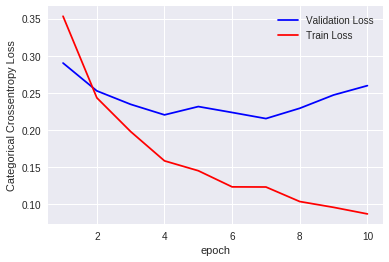

In [34]:
%matplotlib inline 

import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1, 11))

vy = history_1.history['val_loss']
ty = history_1.history['loss']
plt.grid()
plt_dynamic(x, vy, ty, ax)


## LSTM with 2Hidden layers

In [35]:
# create the model
embedding_vecor_length = 32

# Initialising the model
model_2 = Sequential()

# Adding embedding
model_2.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))

# Adding first LSTM layer
model_2.add(LSTM(100,return_sequences=True, dropout=0.4, recurrent_dropout=0.4))

# Adding second LSTM layer
model_2.add(LSTM(100, dropout=0.4, recurrent_dropout=0.4))

# Adding output layer
model_2.add(Dense(1, activation='sigmoid'))

# Printing the model summary
print(model_2.summary())

# Compiling the model
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the data to the model
history_2 = model_2.fit(X_train, y_train, nb_epoch=10, batch_size=512 ,verbose=1,validation_data=(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 400, 32)           160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 400, 100)          53200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 293,701
Trainable params: 293,701
Non-trainable params: 0
_________________________________________________________________
None
Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 181s 4ms/step - loss: 0.3529 - acc: 0.8858 - val_loss: 0.3063 - val_acc: 0.8866
Epoch 2/10
42000/42000 [==============================] - 180s 4ms/step - l

In [36]:
# Final evaluation of the model
scores = model_2.evaluate(X_train, y_train, verbose=0)
print("Train Accuracy: %.2f%%" % (scores[1]*100))

# Final evaluation of the model
scores = model_2.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

# Test and train accuracy of the model
model_2_test = scores[1]
model_2_train = max(history_2.history['acc'])


Train Accuracy: 90.45%
Test Accuracy: 88.95%


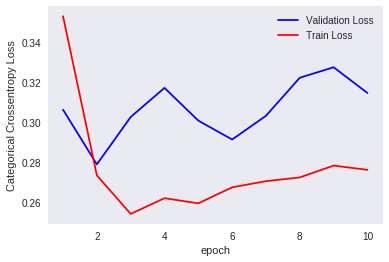

In [37]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,11))

# Validation loss
vy = history_2.history['val_loss']
# Training loss
ty = history_2.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty,ax)

## LSTM With 3-Hidden layers

In [38]:
# create the model
embedding_vecor_length = 32

# Initialising the model
model_3 = Sequential()

# Adding embedding
model_3.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))

# Adding first LSTM layer
model_3.add(LSTM(100,return_sequences=True, dropout=0.4, recurrent_dropout=0.4))

# Adding second LSTM layer
model_3.add(LSTM(100,return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

# Adding third LSTM layer
model_3.add(LSTM(100, dropout=0.4, recurrent_dropout=0.4))

# Adding output layer
model_3.add(Dense(1, activation='relu'))

# Printing the model summary
print(model_3.summary())

# Compiling the model
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the data to the model
history_3 = model_3.fit(X_train, y_train, nb_epoch=10, batch_size=1024 ,verbose=1,validation_data=(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 400, 32)           160000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 400, 100)          53200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 400, 100)          80400     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 374,101
Trainable params: 374,101
Non-trainable params: 0
_________________________________________________________________
None
Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 194s 5ms/step - loss: 1

In [39]:
# Final evaluation of the model
scores = model_3.evaluate(X_train, y_train, verbose=0)
print("Train Accuracy: %.2f%%" % (scores[1]*100))

# Final evaluation of the model
scores = model_3.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

# Test and train accuracy of the model
model_3_test = scores[1]
model_3_train = max(history_3.history['acc'])


Train Accuracy: 88.99%
Test Accuracy: 87.61%


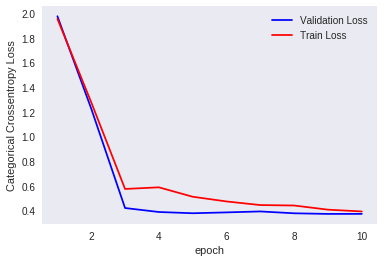

In [40]:
# Plotting Train and Test Loss VS no. of epochs
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,11))

# Validation loss
vy = history_3.history['val_loss']
# Training loss
ty = history_3.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty,ax)

## CONCLUSIONS

In [3]:
from prettytable import PrettyTable
print("\n Model performance table of LSTM")    
x = PrettyTable()
x.field_names=["Model","Training Accuracy","Test Accuracy"]

x.add_row(["RNN With 1 LSTM Layer", 97.81,92.76,])
x.add_row(["RNN With 2 LSTM Layer",90.45  ,88.95])
x.add_row(["RNN With 3 LSTM Layer",88.99 ,87.61])
print(x)




 Model performance table of LSTM
+-----------------------+-------------------+---------------+
|         Model         | Training Accuracy | Test Accuracy |
+-----------------------+-------------------+---------------+
| RNN With 1 LSTM Layer |       97.81       |     92.76     |
| RNN With 2 LSTM Layer |       90.45       |     88.95     |
| RNN With 3 LSTM Layer |       88.99       |     87.61     |
+-----------------------+-------------------+---------------+


#Steps Involved:
  
1) Connecting SQL file

2) Data Cleaning

3) Sorting the data based on time

4) Taking 1st 60K Rows 

5) Data Preprocessing

6) Tokenization

7) Getting Vocabulary of each word

8) Getting Frequency of each word

9) Index of each word

10) Spliting data into train and test based on time (70:30)

11) padding

12) Running LSTM model

13) Conclusion